In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="whitegrid")
pd.set_option('display.max_columns', None)

In [2]:
from useful_functions import synthetic_control_weights, plot_synthetic_weights
from useful_functions import placebo_test, mspe, plot_mspe_ratio, plot_cumulative_treatment_effect

## Joesley Day

In [3]:
# Open dataset and normalize data
df = pd.read_csv('joesley_day.csv', index_col=['Date'])
df = df.loc['2017-02-16':'2017-05-23', :]

df_norm = df.pct_change().dropna()

print(df_norm.shape)

(66, 44)


In [4]:
# Define intervention date
treatment_date = "2017-05-17"
t0 = df_norm.index.get_loc(treatment_date)

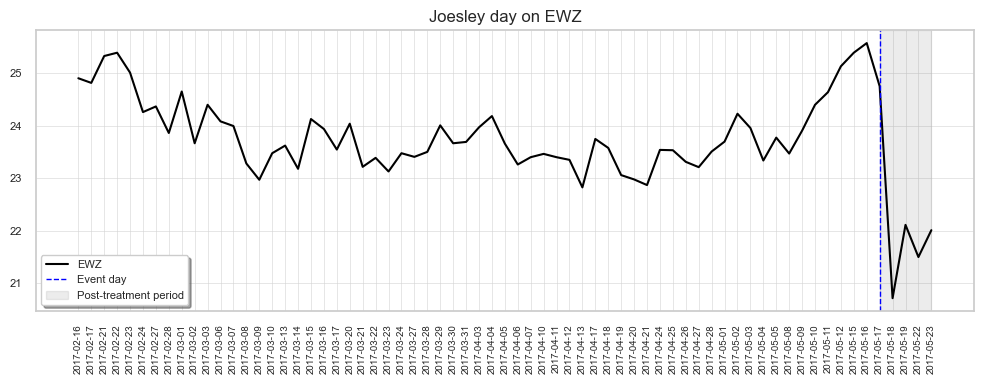

In [5]:
# Plot chart
plt.rcParams["grid.color"] = "lightgray"
plt.rcParams["grid.linewidth"] = 0.4
plt.figure(figsize=(10, 4))

plt.plot(df['EWZ'], label='EWZ', color="black")

plt.axvline(treatment_date, color="blue", linestyle="--", linewidth=1, label="Event day")
plt.axvspan(treatment_date, df.index[-1], color="gray", alpha=0.15, label="Post-treatment period")

plt.xticks(rotation=90, fontsize=7)
plt.yticks(fontsize=8)
plt.title("Joesley day on EWZ")
plt.legend(frameon=True, fancybox=True, shadow=True, fontsize=8)
plt.tight_layout()
plt.show()

In [6]:
# Separate treated and donors
treated = df_norm["EWZ"]
donors = df_norm.drop(columns=["EWZ"])

# Separate pre treatment dataset
Y1_pre = treated[treated.index < treatment_date].values
Y0_pre = donors[donors.index < treatment_date].values
print(Y0_pre.shape, Y0_pre.shape)

(61, 43) (61, 43)


### Canonical Synthetic Control
Compute donor weights for Synthetic Control following Abadie's restrictions
* weights are all positive
* weights add up to one

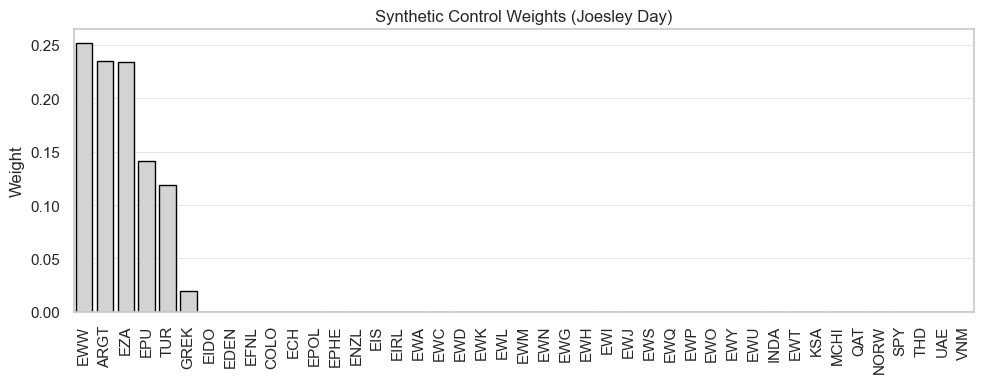

In [7]:
# Calculate weights
weights = synthetic_control_weights(Y1_pre, Y0_pre)

# Apply weights
EWZ_synth_canon = weights @ donors.T

# Plot choosen weights
selected = {
    etf: w for etf, w in zip(donors.columns, weights.round(3)) 
}

plot_synthetic_weights(
    selected,
    title='Synthetic Control Weights (Joesley Day)',
    figsize=(10,4)
)

### OLS method

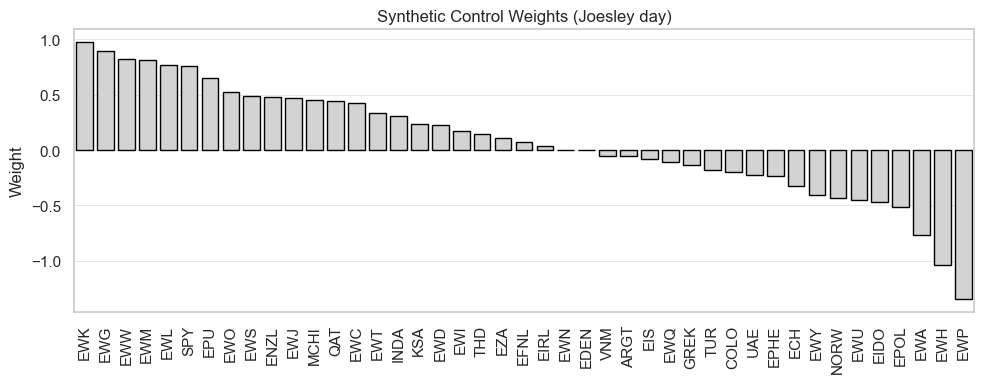

In [8]:
# Find weights without restrictions (short selling)

# OLS without intercept
ols_model = sm.OLS(Y1_pre, Y0_pre).fit()

weights = ols_model.params

# Apply weights
EWZ_synth_ols = weights @ donors.T

# Plot choosen weights
selected = {
    etf: w for etf, w in zip(donors.columns, weights.round(3)) 
}

plot_synthetic_weights(
    selected,
    title='Synthetic Control Weights (Joesley day)',
    figsize=(10,4)
)

### Results

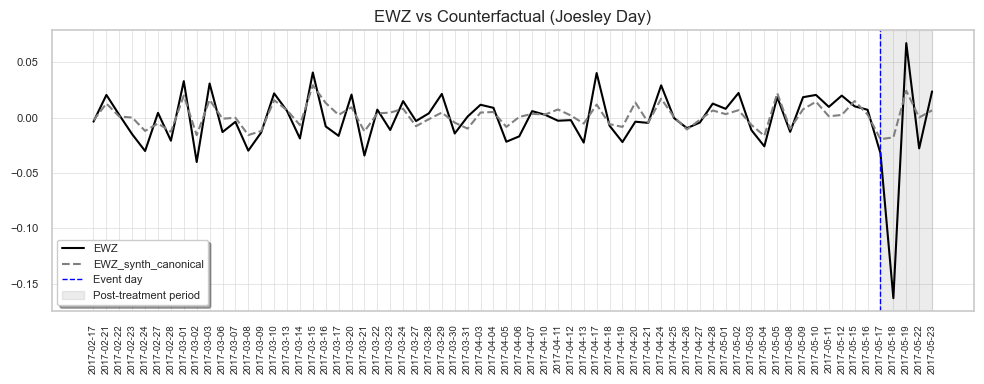

In [9]:
# Plot treated and counterfactual
plt.rcParams["grid.color"] = "lightgray"
plt.rcParams["grid.linewidth"] = 0.4
plt.figure(figsize=(10, 4))

plt.plot(df_norm.index, treated,  color="black", label='EWZ')
plt.plot(df_norm.index, EWZ_synth_canon, color="grey", linestyle="--", label='EWZ_synth_canonical')
#plt.plot(df_norm.index, EWZ_synth_ols, linestyle="--", label='EWZ_synth_ols')

plt.axvline(t0, color="blue", linestyle="--", linewidth=1, label="Event day")
plt.axvspan(treatment_date, df_norm.index[-1], color="gray", alpha=0.15, label="Post-treatment period")

plt.xticks(rotation=90, fontsize=7)
plt.yticks(fontsize=8)
plt.title("EWZ vs Counterfactual (Joesley Day)")
plt.legend(frameon=True, fancybox=True, shadow=True, fontsize=8)
plt.tight_layout()
plt.show()

In [10]:
# Calculate MSPE and MSPE ratio
treated_pre = treated[treated.index < treatment_date]
treated_post = treated[treated.index >= treatment_date]

synth_pre_canon = EWZ_synth_canon[EWZ_synth_canon.index < treatment_date]
synth_post_canon = EWZ_synth_canon[EWZ_synth_canon.index >= treatment_date]

synth_pre_ols = EWZ_synth_ols[EWZ_synth_ols.index < treatment_date]
synth_post_ols = EWZ_synth_ols[EWZ_synth_ols.index >= treatment_date]

mspe_pre = mspe(treated_pre, synth_pre_canon)
mspe_post = mspe(treated_post, synth_post_canon)
mspe_ratio = mspe_post / mspe_pre

print(round(mspe_pre, 6), round(mspe_post, 6), round(mspe_ratio, 6))

0.000134 0.004852 36.268506


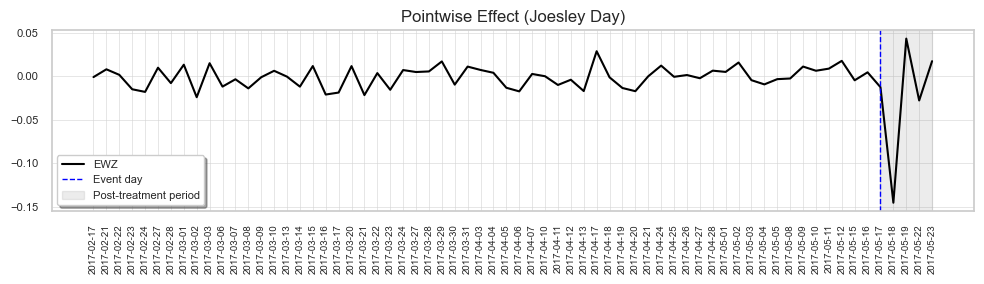

In [11]:
# Plot pointwise effect (GAP)
plt.rcParams["grid.color"] = "lightgray"
plt.rcParams["grid.linewidth"] = 0.4
plt.figure(figsize=(10, 3))

plt.plot(df_norm.index, treated - EWZ_synth_canon, color="black", label='EWZ')
plt.axvline(t0, color="blue", linestyle="--", linewidth=1, label="Event day")
plt.axvspan(treatment_date, df_norm.index[-1], color="gray", alpha=0.15, label="Post-treatment period")

plt.xticks(rotation=90, fontsize=7)
plt.yticks(fontsize=8)
plt.title("Pointwise Effect (Joesley Day)")
plt.legend(frameon=True, fancybox=True, shadow=True, fontsize=8)
plt.tight_layout()
plt.show()

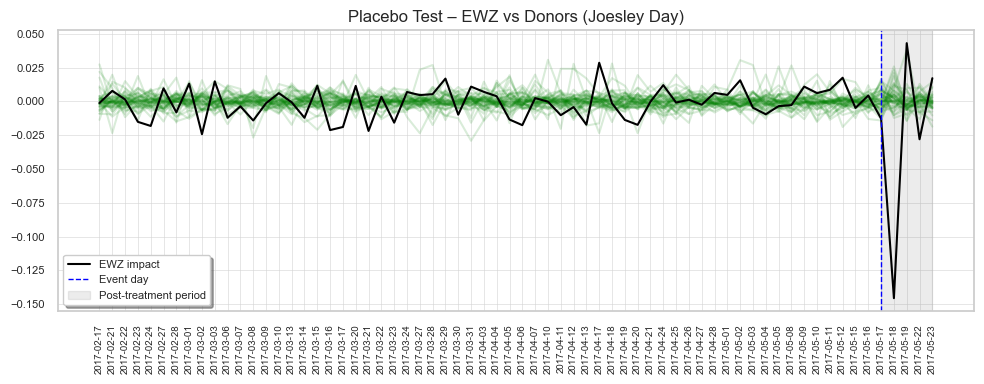

In [12]:
# Placebo test
placebo_gap = placebo_test(df_norm, treatment_date) # canonical method
#placebo_gap = placebo_test(df_norm, treatment_date, weight_calculus='ols') # ols method

treated_gap = placebo_gap['EWZ']
placebo_gap.pop("EWZ")

# Plot
plt.figure(figsize=(10,4))
for k in placebo_gap:
    plt.plot(placebo_gap[k].index, placebo_gap[k].values, color="green", alpha=0.15)
plt.plot(df_norm.index, treated_gap, color="black", label='EWZ impact')

plt.axvline(t0, color="blue", linestyle="--", linewidth=1, label="Event day")
plt.axvspan(treatment_date, df_norm.index[-1], color="gray", alpha=0.15, label="Post-treatment period")

plt.xticks(rotation=90, fontsize=7)
plt.yticks(fontsize=8)
plt.title("Placebo Test – EWZ vs Donors (Joesley Day)")
plt.legend(frameon=True, fancybox=True, shadow=True, fontsize=8)
plt.tight_layout()
plt.show()

In [13]:
# MSPE pre-treatment
mspe_treated_pre = float(np.mean(treated_gap[:t0]**2))
mspe_placebo_pre = {k: float(np.mean((placebo_gap[k][:t0].values)**2)) for k in placebo_gap}

# MSPE post-treatment
mspe_treated_post = float(np.mean(treated_gap[t0:]**2))
mspe_placebo_post = {k: float(np.mean((placebo_gap[k][t0:].values)**2)) for k in placebo_gap}

# MSPE ratio
mspe_ratio_treated = mspe_treated_post / mspe_treated_pre
mspe_ratio_placebo = [mspe_placebo_post[i] / mspe_placebo_pre[i] for i in mspe_placebo_pre]

# p-value
p_value = np.mean(mspe_ratio_placebo >= np.array(mspe_ratio_treated))
print(f"p-value: {p_value}")

p-value: 0.0


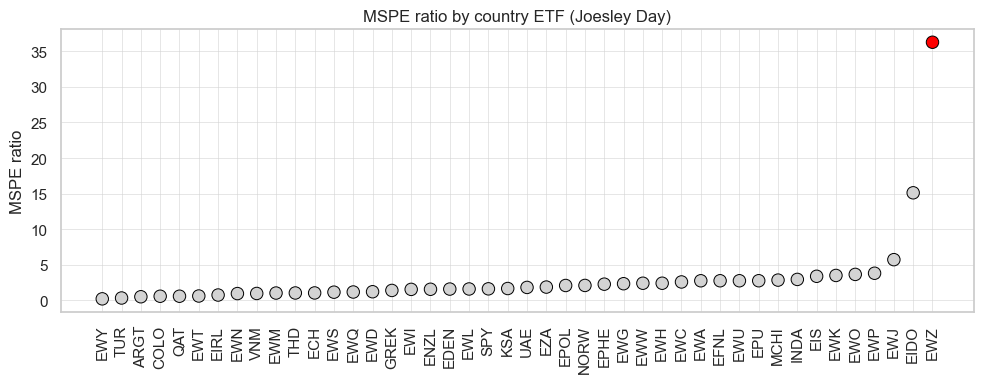

In [14]:
# Plot MSPE
mspe_plot = pd.DataFrame(
    {'mspe_ratio': mspe_ratio_placebo},
    index=mspe_placebo_pre.keys()
)
mspe_plot.loc['EWZ'] = mspe_ratio_treated
mspe_plot.sort_values('mspe_ratio', inplace=True)

plot_mspe_ratio(mspe_plot, treated_label='EWZ', title="MSPE ratio by country ETF (Joesley Day)", figsize=(10,4))

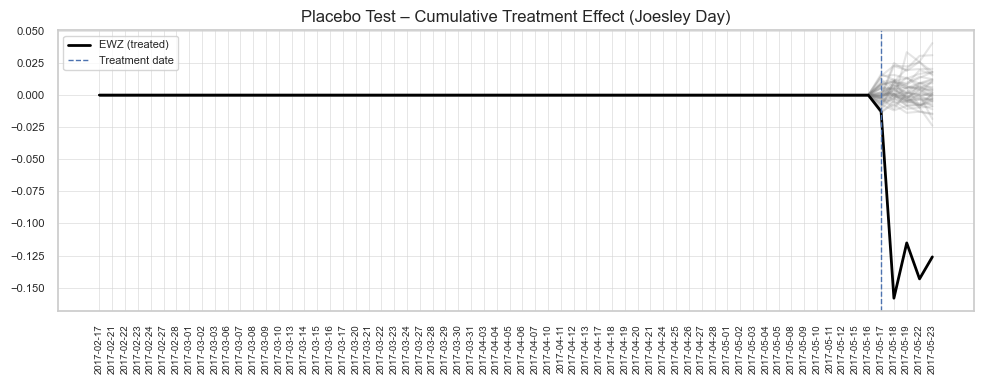

In [15]:
plot_cumulative_treatment_effect(
    treated_gap,
    placebo_gap,
    treatment_date,
    title="Placebo Test – Cumulative Treatment Effect (Joesley Day)"
)

## Covid-19

In [16]:
df = pd.read_csv("covid.csv", index_col=['Date'])
df = df.loc['2019-11-18':'2020-03-23', :]

#df_norm = np.log(df / df.shift(1)).dropna()
df_norm = df.pct_change().dropna()
print(df_norm.shape)

(85, 44)


In [17]:
# Define intervention date
treatment_date = "2020-02-20"
t0 = df_norm.index.get_loc(treatment_date)

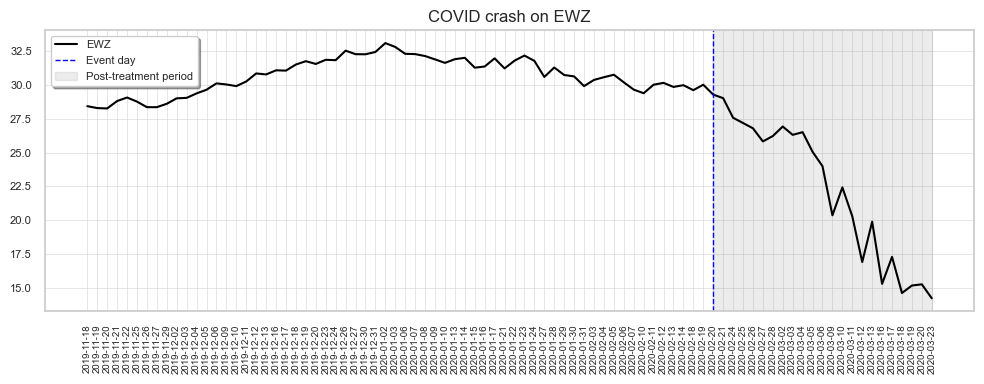

In [18]:
# Plot chart
plt.rcParams["grid.color"] = "lightgray"
plt.rcParams["grid.linewidth"] = 0.4
plt.figure(figsize=(10, 4))

plt.plot(df['EWZ'], label='EWZ', color="black")

plt.axvline(treatment_date, color="blue", linestyle="--", linewidth=1, label="Event day")
plt.axvspan(treatment_date, df.index[-1], color="gray", alpha=0.15, label="Post-treatment period")

plt.xticks(rotation=90, fontsize=7)
plt.yticks(fontsize=8)
plt.title("COVID crash on EWZ")
plt.legend(frameon=True, fancybox=True, shadow=True, fontsize=8)
plt.tight_layout()
plt.show()

In [19]:
# Separate treated and donors
treated = df_norm["EWZ"]
donors = df_norm.drop(columns=["EWZ"])

# Separate pre treatment dataset
Y1_pre = treated[treated.index < treatment_date].values
Y0_pre = donors[donors.index < treatment_date].values
print(Y0_pre.shape, Y0_pre.shape)

(62, 43) (62, 43)


### Canonical Synthetic Control
Compute donor weights for Synthetic Control following Abadie's restrictions
* weights are all positive
* weights add up to one

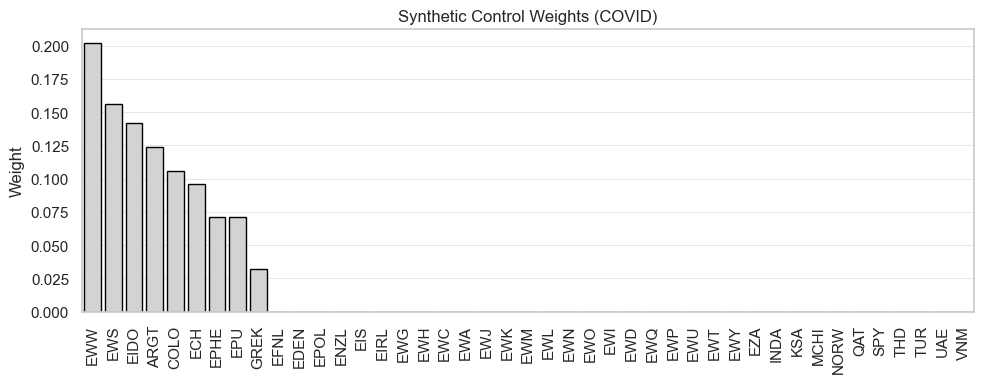

In [20]:
# Calculate weights
weights = synthetic_control_weights(Y1_pre, Y0_pre)

# Apply weights
EWZ_synth_canon = weights @ donors.T

# Plot choosen weights
selected = {
    etf: w for etf, w in zip(donors.columns, weights.round(3)) 
}

plot_synthetic_weights(
    selected,
    title='Synthetic Control Weights (COVID)',
    figsize=(10,4)
)

### OLS method

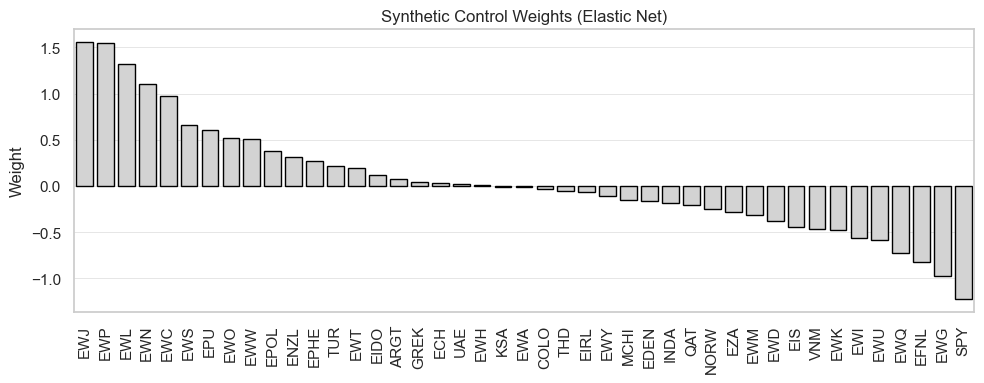

In [21]:
# Find weights without restrictions (short selling)

# OLS without intercept
ols_model = sm.OLS(Y1_pre, Y0_pre).fit()

weights = ols_model.params

# Apply weights
EWZ_synth_ols = weights @ donors.T

# Plot choosen weights
selected = {
    etf: w for etf, w in zip(donors.columns, weights.round(3)) 
}

plot_synthetic_weights(
    selected,
    title='Synthetic Control Weights (Elastic Net)',
    figsize=(10,4)
)

### Results

In [22]:
# Calculate MSPE and MSPE ratio
treated_pre = treated[treated.index < treatment_date]
treated_post = treated[treated.index >= treatment_date]

synth_pre_canon = EWZ_synth_canon[EWZ_synth_canon.index < treatment_date]
synth_post_canon = EWZ_synth_canon[EWZ_synth_canon.index >= treatment_date]

synth_pre_ols = EWZ_synth_ols[EWZ_synth_ols.index < treatment_date]
synth_post_ols = EWZ_synth_ols[EWZ_synth_ols.index >= treatment_date]

mspe_pre = mspe(treated_pre, synth_pre_canon)
mspe_post = mspe(treated_post, synth_post_canon)
mspe_ratio = mspe_post / mspe_pre

print(round(mspe_pre, 6), round(mspe_post, 6), round(mspe_ratio, 6))

8.3e-05 0.002251 26.992033


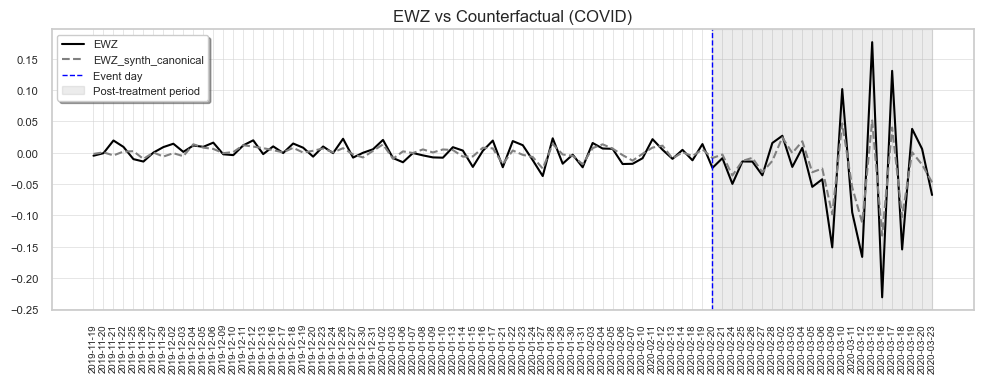

In [23]:
# Plot treated and counterfactual
plt.rcParams["grid.color"] = "lightgray"
plt.rcParams["grid.linewidth"] = 0.4
plt.figure(figsize=(10, 4))

plt.plot(df_norm.index, treated,  color="black", label='EWZ')
plt.plot(df_norm.index, EWZ_synth_canon, color="grey", linestyle="--", label='EWZ_synth_canonical')
#plt.plot(df_norm.index, EWZ_synth_ols, linestyle="--", label='EWZ_synth_ols')

plt.axvline(t0, color="blue", linestyle="--", linewidth=1, label="Event day")
plt.axvspan(treatment_date, df_norm.index[-1], color="gray", alpha=0.15, label="Post-treatment period")

plt.xticks(rotation=90, fontsize=7)
plt.yticks(fontsize=8)
plt.title("EWZ vs Counterfactual (COVID)")
plt.legend(frameon=True, fancybox=True, shadow=True, fontsize=8)
plt.tight_layout()
plt.show()

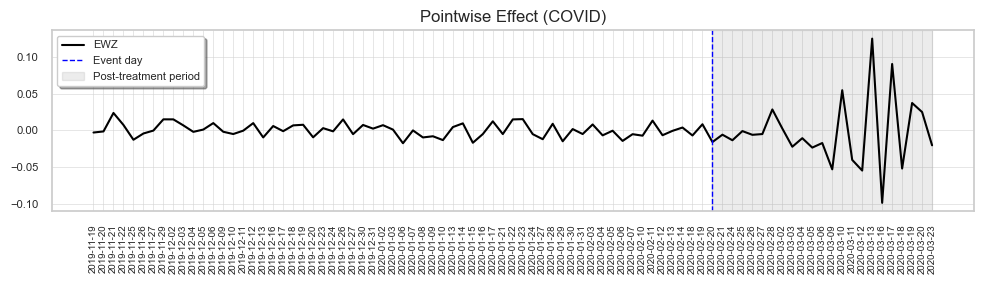

In [24]:
# Plot pointwise effect (GAP)
plt.rcParams["grid.color"] = "lightgray"
plt.rcParams["grid.linewidth"] = 0.4
plt.figure(figsize=(10, 3))

plt.plot(df_norm.index, treated - EWZ_synth_canon, color="black", label='EWZ')
plt.axvline(t0, color="blue", linestyle="--", linewidth=1, label="Event day")
plt.axvspan(treatment_date, df_norm.index[-1], color="gray", alpha=0.15, label="Post-treatment period")

plt.xticks(rotation=90, fontsize=7)
plt.yticks(fontsize=8)
plt.title("Pointwise Effect (COVID)")
plt.legend(frameon=True, fancybox=True, shadow=True, fontsize=8)
plt.tight_layout()
plt.show()

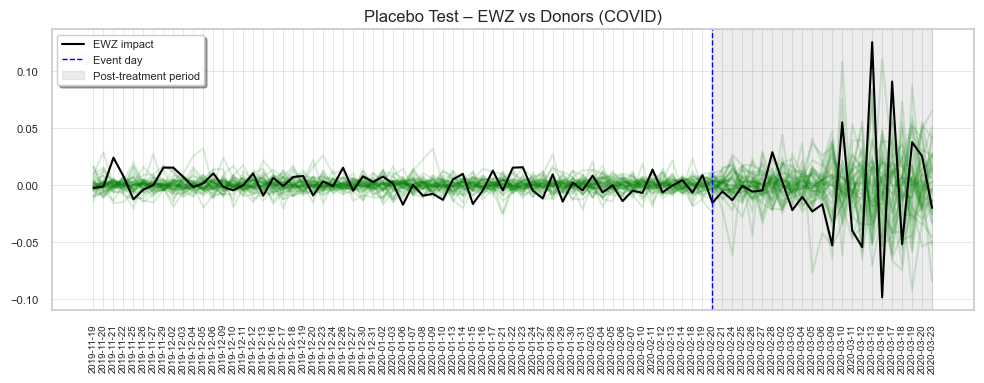

In [25]:
# Placebo test
placebo_gap = placebo_test(df_norm, treatment_date) # canonical method
#placebo_gap = placebo_test(df_norm, treatment_date, weight_calculus='ols') # ols method

treated_gap = placebo_gap['EWZ']
placebo_gap.pop("EWZ")

# Plot
plt.figure(figsize=(10,4))
for k in placebo_gap:
    plt.plot(placebo_gap[k].index, placebo_gap[k].values, color="green", alpha=0.15)
plt.plot(df_norm.index, treated_gap, color="black", label='EWZ impact')

plt.axvline(t0, color="blue", linestyle="--", linewidth=1, label="Event day")
plt.axvspan(treatment_date, df_norm.index[-1], color="gray", alpha=0.15, label="Post-treatment period")

plt.xticks(rotation=90, fontsize=7)
plt.yticks(fontsize=8)
plt.title("Placebo Test – EWZ vs Donors (COVID)")
plt.legend(frameon=True, fancybox=True, shadow=True, fontsize=8)
plt.tight_layout()
plt.show()

In [26]:
# MSPE pre-treatment
mspe_treated_pre = float(np.mean(treated_gap[:t0]**2))
mspe_placebo_pre = {k: float(np.mean((placebo_gap[k][:t0].values)**2)) for k in placebo_gap}

# MSPE post-treatment
mspe_treated_post = float(np.mean(treated_gap[t0:]**2))
mspe_placebo_post = {k: float(np.mean((placebo_gap[k][t0:].values)**2)) for k in placebo_gap}

# MSPE ratio
mspe_ratio_treated = mspe_treated_post / mspe_treated_pre
mspe_ratio_placebo = [mspe_placebo_post[i] / mspe_placebo_pre[i] for i in mspe_placebo_pre]

# p-value
p_value = np.mean(mspe_ratio_placebo >= np.array(mspe_ratio_treated))
print(f"p-value: {p_value}")

p-value: 0.20930232558139536


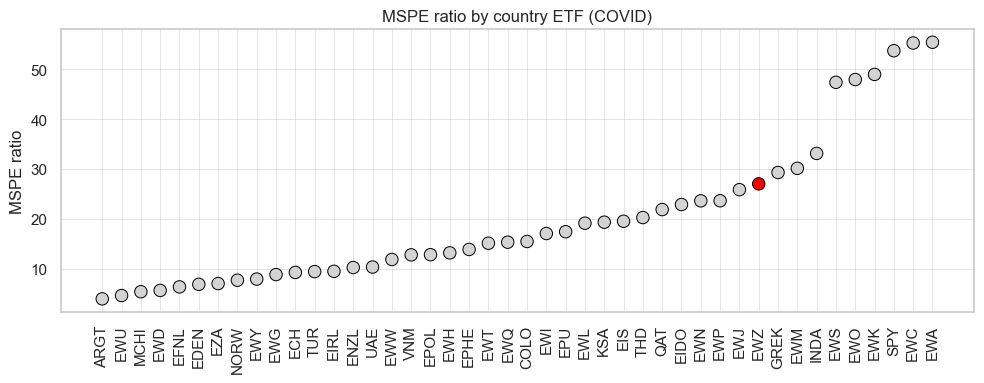

In [27]:
# Plot MSPE
mspe_plot = pd.DataFrame(
    {'mspe_ratio': mspe_ratio_placebo},
    index=mspe_placebo_pre.keys()
)
mspe_plot.loc['EWZ'] = mspe_ratio_treated
mspe_plot.sort_values('mspe_ratio', inplace=True)

plot_mspe_ratio(mspe_plot, treated_label='EWZ', title="MSPE ratio by country ETF (COVID)", figsize=(10,4))

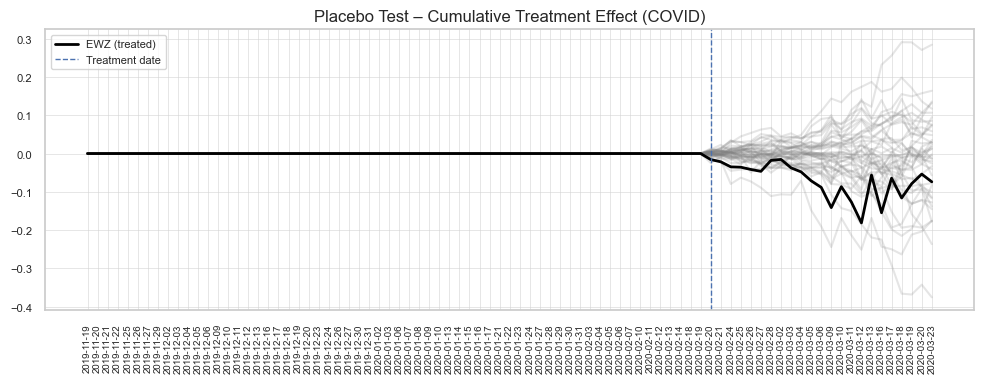

In [28]:
plot_cumulative_treatment_effect(
    treated_gap,
    placebo_gap,
    treatment_date,
    title="Placebo Test – Cumulative Treatment Effect (COVID)"
)


-----